## Section 1 : Imports

In [1]:
import numpy as np
import pandas as pd
import requests
import zipfile
import io
from datetime import datetime
import random
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import urllib
import time
from datetime import datetime
import calendar
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Section 2 : Run Time File Reading
#### For the Weather data this couldn't be replicated as it required an api call and since I was finishing other work, I couldn't try the bluemix api

#### Step 1: Downloading the file as run time and unzipping it

In [2]:
!curl -O "https://s3.amazonaws.com/tripdata/2017[01-12]-citibike-tripdata.csv.zip"
!unzip '*.zip'
!rm *.zip


[1/12]: https://s3.amazonaws.com/tripdata/201701-citibike-tripdata.csv.zip --> 201701-citibike-tripdata.csv.zip
--_curl_--https://s3.amazonaws.com/tripdata/201701-citibike-tripdata.csv.zip
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23.1M  100 23.1M    0     0  8933k      0  0:00:02  0:00:02 --:--:-- 8933k

[2/12]: https://s3.amazonaws.com/tripdata/201702-citibike-tripdata.csv.zip --> 201702-citibike-tripdata.csv.zip
--_curl_--https://s3.amazonaws.com/tripdata/201702-citibike-tripdata.csv.zip
100 25.1M  100 25.1M    0     0  8259k      0  0:00:03  0:00:03 --:--:-- 8519k

[3/12]: https://s3.amazonaws.com/tripdata/201703-citibike-tripdata.csv.zip --> 201703-citibike-tripdata.csv.zip
--_curl_--https://s3.amazonaws.com/tripdata/201703-citibike-tripdata.csv.zip
100 23.0M  100 23.0M    0     0  8610k      0  0:00:02  0:00:02 --:--:-- 8586k

[4/12]: https://s3.amazonaws.com/t

In [3]:
# Get file names and sort in chronological order
filenames = glob.glob('*.csv')
filenames.sort()
filenames

['201701-citibike-tripdata.csv',
 '201702-citibike-tripdata.csv',
 '201703-citibike-tripdata.csv',
 '201704-citibike-tripdata.csv',
 '201705-citibike-tripdata.csv',
 '201706-citibike-tripdata.csv',
 '201707-citibike-tripdata.csv',
 '201708-citibike-tripdata.csv',
 '201709-citibike-tripdata.csv',
 '201710-citibike-tripdata.csv',
 '201711-citibike-tripdata.csv',
 '201712-citibike-tripdata.csv']

In [4]:
# Loop through file names and read the data
dfs = []
for file in filenames:
    print('Reading ' + file)
    dfs.append(pd.read_csv(file))

Reading 201701-citibike-tripdata.csv
Reading 201702-citibike-tripdata.csv
Reading 201703-citibike-tripdata.csv
Reading 201704-citibike-tripdata.csv
Reading 201705-citibike-tripdata.csv
Reading 201706-citibike-tripdata.csv
Reading 201707-citibike-tripdata.csv
Reading 201708-citibike-tripdata.csv
Reading 201709-citibike-tripdata.csv
Reading 201710-citibike-tripdata.csv
Reading 201711-citibike-tripdata.csv
Reading 201712-citibike-tripdata.csv


#### Step 2: Checking the files downloaded & making the homogeneous, Also deleting the csv files that were unzipped earlier to save space.

In [5]:
dfs[0].head(2)

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,3226,W 82 St & Central Park West,40.782750,-73.971370,3165,Central Park West & W 72 St,40.775794,-73.976206,25542,Subscriber,1965.0,2
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263,Cooper Square & E 7 St,40.729236,-73.990868,498,Broadway & W 32 St,40.748549,-73.988084,21136,Subscriber,1987.0,2


In [6]:
dfs[11].head(2)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,256,2017-12-01 00:00:00,2017-12-01 00:04:17,324,DeKalb Ave & Hudson Ave,40.689888,-73.981013,262,Washington Park,40.691782,-73.973730,18858,Subscriber,1981.0,1
1,325,2017-12-01 00:00:17,2017-12-01 00:05:43,470,W 20 St & 8 Ave,40.743453,-74.000040,490,8 Ave & W 33 St,40.751551,-73.993934,19306,Subscriber,1992.0,1


In [7]:
# Remove .csv files as we no longer need them
!rm *.csv

In [8]:
## Creating a standard column name
print('Standardizing Month:')
for month in range(12):
    if month < 3:
        print('... ' + str(month + 1))
        dfs[month]['tripduration'] = dfs[month]['Trip Duration']
        dfs[month]['starttime'] = pd.to_datetime(dfs[month]['Start Time'])
        dfs[month]['stoptime'] = pd.to_datetime(dfs[month]['Stop Time'])
        dfs[month]['startstationid'] = dfs[month]['Start Station ID']
        dfs[month]['startstationname'] =dfs[month]['Start Station Name']
        dfs[month]['startstationlatitude'] = dfs[month]['Start Station Latitude']
        dfs[month]['startstationlongitude'] = dfs[month]['Start Station Longitude']
        dfs[month]['endstationid'] = dfs[month]['End Station ID']
        dfs[month]['endstationname'] = dfs[month]['End Station Name']
        dfs[month]['endstationlatitude'] = dfs[month]['End Station Latitude']
        dfs[month]['endstationlongitude'] = dfs[month]['End Station Longitude']
        dfs[month]['bikeid'] = dfs[month]['Bike ID']
        dfs[month]['usertype'] = dfs[month]['User Type']
        dfs[month]['birthyear'] = dfs[month]['Birth Year']
        dfs[month]['gender'] = dfs[month]['Gender']
    else:
        print('... ' + str(month + 1))
        dfs[month]['tripduration'] = dfs[month]['tripduration']
        dfs[month]['starttime'] = pd.to_datetime(dfs[month]['starttime'])
        dfs[month]['stoptime'] = pd.to_datetime(dfs[month]['stoptime'])
        dfs[month]['startstationid'] = dfs[month]['start station id']
        dfs[month]['startstationname'] = dfs[month]['start station name']
        dfs[month]['startstationlatitude'] = dfs[month]['start station latitude']
        dfs[month]['startstationlongitude'] = dfs[month]['start station longitude']
        dfs[month]['endstationid'] = dfs[month]['end station id']
        dfs[month]['endstationname'] = dfs[month]['end station name']
        dfs[month]['endstationlatitude'] = dfs[month]['end station latitude']
        dfs[month]['endstationlongitude'] = dfs[month]['end station longitude']
        dfs[month]['bikeid'] = dfs[month]['bikeid']
        dfs[month]['usertype'] = dfs[month]['usertype']
        dfs[month]['birthyear'] = dfs[month]['birth year']
        dfs[month]['gender'] = dfs[month]['gender']    

Standardizing Month:
... 1
... 2
... 3
... 4
... 5
... 6
... 7
... 8
... 9
... 10
... 11
... 12


In [9]:
# concatting the dataset to form a dataframe
df = pd.concat(dfs)

In [10]:
# checking the shape of dataframe
df.shape

(16364657, 39)

In [11]:
# checking the type of each column
df.dtypes

Bike ID                           float64
Birth Year                        float64
End Station ID                    float64
End Station Latitude              float64
End Station Longitude             float64
End Station Name                   object
Gender                            float64
Start Station ID                  float64
Start Station Latitude            float64
Start Station Longitude           float64
Start Station Name                 object
Start Time                         object
Stop Time                          object
Trip Duration                     float64
User Type                          object
bikeid                              int64
birth year                        float64
birthyear                         float64
end station id                    float64
end station latitude              float64
end station longitude             float64
end station name                   object
endstationid                        int64
endstationlatitude                

In [12]:
# dropping extra columns
cols =['Bike ID','Birth Year','End Station ID','End Station Latitude','End Station Longitude','End Station Name',
          'Gender','Start Station ID','Start Station Latitude','Start Station Longitude','Start Station Name',
          'Start Time','Stop Time','Trip Duration','User Type','birth year','end station id','end station latitude',
          'end station longitude','end station name','start station id','start station latitude',
          'start station longitude','start station name']

In [13]:
df= df.drop(cols, axis=1)

In [14]:
# checking the shape of dataframe
df.shape

(16364657, 15)

In [15]:
# checking the type of each column
df.dtypes

bikeid                            int64
birthyear                       float64
endstationid                      int64
endstationlatitude              float64
endstationlongitude             float64
endstationname                   object
gender                            int64
startstationid                    int64
startstationlatitude            float64
startstationlongitude           float64
startstationname                 object
starttime                datetime64[ns]
stoptime                 datetime64[ns]
tripduration                      int64
usertype                         object
dtype: object

In [16]:
# making a pkl file to import further as it is faster to load
df.to_pickle('citibike_2017.pkl')

In [17]:
# making a csv file just incase we want to export it outside
df.to_csv('citibike_2017.csv')

## Section 3: Exploratory Analysis
### Step 1: Read the above downloaded file
#### Note :- Start notebook from here if above file exists as above process takes some time

In [2]:
file_name = 'citibike_2017.pkl'
%time citibike = pd.read_pickle(file_name)

CPU times: user 1.8 s, sys: 2.92 s, total: 4.72 s
Wall time: 5.28 s


In [3]:
# checking the shape of the citibike file
citibike.shape

(16364657, 15)

In [4]:
# resetting the index of the citibike file
citibike=citibike.reset_index()

In [5]:
## dropping rows which are completely empty and checking the shape again
citibike= citibike.dropna(how='all')
citibike.shape

(16364657, 16)

### Step 2: Calculating the summary statistics and exploring data to understand it better

In [6]:
# approximate radius of earth in km
# Calculating the distance and speed for above graph and further analysis
R = 6371e3
    
citibike['lat1'] = np.radians(citibike['startstationlatitude'])
citibike['lon1'] = np.radians(citibike['startstationlongitude'])
citibike['lat2'] = np.radians(citibike['endstationlatitude'])
citibike['lon2'] = np.radians(citibike['endstationlongitude'])

citibike['dlon'] = citibike['lon2'] - citibike['lon1']
citibike['dlat'] = citibike['lat2'] - citibike['lat1']

citibike['a'] = ((np.sin(citibike['dlat'] / 2)**2 ) + 
                                 (np.cos(citibike['lat1']) * 
                                  np.cos(citibike['lat2']) * 
                                  (np.sin(citibike['dlon'] / 2)**2)))
citibike['c'] = 2 * np.arctan2(np.sqrt(citibike['a']),
                                               np.sqrt(1 - citibike['a']))

citibike['distance'] = R * citibike['c']/1000

In [7]:
# Dropping columns to smaller the dataframe
del citibike['lat1']
del citibike['lon1']
del citibike['lat2']
del citibike['lon2']
del citibike['dlon']
del citibike['dlat']
del citibike['a']
del citibike['c']

In [8]:
# Summary of the numerical variables
citibike.describe()

,index,bikeid,birthyear,endstationid,endstationlatitude,endstationlongitude,gender,startstationid,startstationlatitude,startstationlongitude,tripduration,distance
count,1.636466e+07,1.636466e+07,1.473432e+07,1.636466e+07,1.636466e+07,1.636466e+07,1.636466e+07,1.636466e+07,1.636466e+07,1.636466e+07,1.636466e+07,1.636466e+07
mean,7.557763e+05,2.375463e+04,1.978895e+03,1.349138e+03,4.073638e+01,-7.398481e+01,1.123459e+00,1.357132e+03,4.073663e+01,-7.398450e+01,9.945862e+02,1.850006e+00
std,4.936921e+05,5.345616e+03,1.183019e+01,1.344688e+03,5.225299e-02,7.950876e-02,5.615377e-01,1.346904e+03,7.262269e-02,1.211708e-01,1.617892e+04,1.595280e+01
min,0.000000e+00,1.452900e+04,1.858000e+03,7.200000e+01,0.000000e+00,-7.408585e+01,0.000000e+00,7.200000e+01,0.000000e+00,-7.403423e+01,6.100000e+01,0.000000e+00
25%,3.409300e+05,1.865300e+04,1.971000e+03,3.590000e+02,4.071850e+01,-7.399704e+01,1.000000e+00,3.610000e+02,4.071871e+01,-7.399662e+01,3.720000e+02,8.591549e-01
50%,6.818600e+05,2.546400e+04,1.982000e+03,4.860000e+02,4.073705e+01,-7.398759e+01,1.000000e+00,4.870000e+02,4.073782e+01,-7.398752e+01,6.210000e+02,1.419187e+00
75%,1.142192e+06,2.811400e+04,1.988000e+03,3.141000e+03,4.075514e+01,-7.397621e+01,1.000000e+00,3.142000e+03,4.075594e+01,-7.397606e+01,1.076000e+03,2.356405e+00
max,1.897591e+06,3.348100e+04,2.001000e+03,3.654000e+03,4.550636e+01,0.000000e+00,2.000000e+00,3.654000e+03,4.550636e+01,0.000000e+00,9.735948e+06,8.672623e+03


In [9]:
citibike[citibike['distance']>10].count()

index                    9236
bikeid                   9236
birthyear                8177
endstationid             9236
endstationlatitude       9236
endstationlongitude      9236
endstationname           9236
gender                   9236
startstationid           9236
startstationlatitude     9236
startstationlongitude    9236
startstationname         9236
starttime                9236
stoptime                 9236
tripduration             9236
usertype                 9234
distance                 9236
dtype: int64

In [10]:
citibike['speed'] = citibike['distance'] / ((citibike['tripduration'])/3600)

In [11]:
## getting the current year to calculate the age of the riders
now = datetime.now()
curr_year = now.year

In [12]:
## As usertype customer dont have birthyear in the data, I am replacing the NA with current year so that when I 
## calculate age it turns out 0.
citibike['birthyear']=citibike['birthyear'].fillna(curr_year)

In [13]:
print('There are {} people who are customers but have their birth year in the data'.format(citibike[
    (citibike.usertype =='Customer') & ((citibike.gender == 0) & (citibike.birthyear < curr_year))].shape[0]))
print('And it is {}% out of the whole dataset'.format(round(citibike[
    (citibike.usertype =='Customer') & ((citibike.gender == 0) & 
                                        (citibike.birthyear < curr_year))].shape[1]*100/citibike.shape[0],2)))

There are 3400 people who are customers but have their birth year in the data
And it is 0.0% out of the whole dataset


In [14]:
citibike = citibike.drop(citibike[(citibike.usertype =='Customer') & 
                                  ((citibike.gender == 0) & (citibike.birthyear < curr_year))].index)

In [15]:
print('There are {} people who are customers but have their gender in the data'.format(citibike[
    (citibike.usertype =='Customer') & ((citibike.gender != 0) & (citibike.birthyear == curr_year))].shape[0]))
print('And it is {}% out of the whole dataset'.format(round(citibike[
    (citibike.usertype =='Customer') & ((citibike.gender != 0) & 
                                        (citibike.birthyear == curr_year))].shape[1]*100/citibike.shape[0],2)))

There are 0 people who are customers but have their gender in the data
And it is 0.0% out of the whole dataset


In [16]:
citibike = citibike.drop(citibike[(citibike.usertype =='Customer') & 
                                  ((citibike.gender != 0) & (citibike.birthyear == curr_year))].index)

In [17]:
print('There are {} people who are subscriber but dont have their gender in the data'.format(citibike[
    (citibike.usertype =='Subscriber') & ((citibike.gender == 0) & (citibike.birthyear < curr_year))].shape[0]))
print('And it is {}% out of the whole dataset'.format(round(citibike[
    (citibike.usertype =='Subscriber') & ((citibike.gender == 0) & 
                                        (citibike.birthyear < curr_year))].shape[1]*100/citibike.shape[0],2)))

There are 60918 people who are subscriber but dont have their gender in the data
And it is 0.0% out of the whole dataset


In [18]:
citibike = citibike.drop(citibike[(citibike.usertype =='Subscriber') & 
                                  ((citibike.gender == 0) & (citibike.birthyear < curr_year))].index)

In [19]:
print('There are {} people who are subscriber but dont have their birth year in the data'.format(citibike[
    (citibike.usertype =='Subscriber') & ((citibike.gender != 0) & (citibike.birthyear == curr_year))].shape[0]))
print('And it is {}% out of the whole dataset'.format(round(citibike[
    (citibike.usertype =='Subscriber') & ((citibike.gender != 0) & 
                                        (citibike.birthyear == curr_year))].shape[1]*100/citibike.shape[0],2)))

There are 308 people who are subscriber but dont have their birth year in the data
And it is 0.0% out of the whole dataset


In [20]:
citibike = citibike.drop(citibike[(citibike.usertype =='Subscriber') & 
                                  ((citibike.gender != 0) & (citibike.birthyear == curr_year))].index)

In [21]:
## Creating a new variable user based on the fact that customers shouldn't have gender and birth year while 
## Subscribers should have both within the data
citibike['user']=np.where((citibike['gender']== 0)&(citibike['birthyear']==curr_year),'Customer','Subscriber')

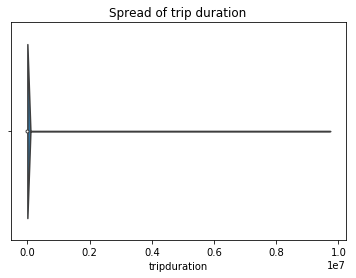

In [22]:
## trying to see the skew of the tripduration
sns.violinplot(citibike['tripduration'])
plt.title('Spread of trip duration')
plt.show()

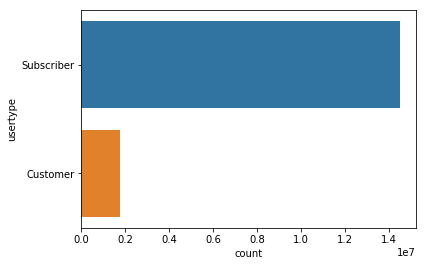

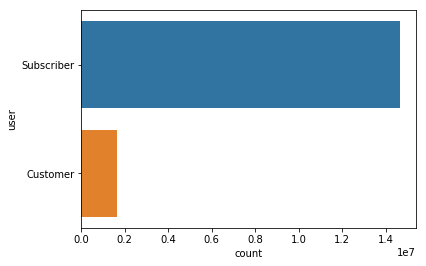

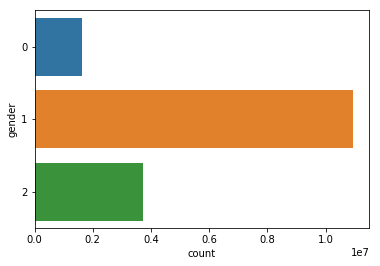

In [23]:
# categorical data split and trying to understand the data
for feature in ['usertype', 'user' ,'gender']:
    sns.countplot(data=citibike, y=feature)
    plt.show()

In [24]:
# Dropping columns to smaller the dataframe
del citibike['usertype']

### Step 3: Cleaning the data

#### We can see that the distribution of 'Distance' is highly right-skewed, which means there's potential outliers. Let's find out what percentage of trips in the dataset taken less than 10 miles. As per the ridership plan it is safe to estimate that trips greater than 10 miles is highly unlikely. Plus since this is euclidean distance( which is shortest distance, the actual distance could be much more.

In [25]:
print('Maximum value of trip distance : {} miles'.format(round(citibike['distance'].max(), 2)))
print('There are {} trips taken less than 10 miles'.format(citibike[citibike['distance'] <= 10].shape[0]))
print('And it is {}% out of the whole dataset'.format(round(
    citibike[citibike['distance'] <= 10].shape[0]*100/citibike.shape[0],2)))

Maximum value of trip distance : 8672.62 miles
There are 16290818 trips taken less than 10 miles
And it is 99.94% out of the whole dataset


In [26]:
citibike = citibike[citibike['distance'] <= 10]

#### It's s safe to remove rows which has 'Distance' > 10 miles as I only lose 0.06% of data as they could be outliers.

#### We can see that the distribution of 'Trip Duration' is highly right-skewed, which means there's potential outliers. Let's find out what percentage of trips in the dataset taken less than an hour. As per the ridership plan it is safe to estimate that trips greater than hour is highly unlikely as for customer they would have paid additional charges twice by now and subscribers would have also inccured additonal charges.

In [27]:
print('Maximum value of trip duration : {} days'.format(round(citibike['tripduration'].max()/(3600*24), 2)))
print('There are {} trips taken less than an hour'.format(citibike[citibike['tripduration'] <= 3600].shape[0]))
print('And it is {}% out of the whole dataset'.format(round(
    citibike[citibike['tripduration'] <= 3600].shape[0]*100/citibike.shape[0],2)))

Maximum value of trip duration : 112.68 days
There are 16142797 trips taken less than an hour
And it is 99.09% out of the whole dataset


#### It's s safe to remove rows which has 'Trip Duration' > 3600 as I only lose 0.91% of data as they could be outliers.

In [28]:
citibike_outlier_removed = citibike[citibike['tripduration'] <= 3600]

In [29]:
## Created Age column based on birth year
citibike_outlier_removed['Age'] = curr_year - citibike_outlier_removed['birthyear']

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### From the describe called earlier we can see that Oldest rider is 160 year old but after reading online reagrding this I have decided to remove riders above 75 years old.

In [30]:
print('There are {} riders above the age of 75'.format(
    citibike_outlier_removed[citibike_outlier_removed['Age'] > 75].shape[0]))
print('And it is {}% out of the whole dataset'.format(round(
    citibike_outlier_removed[citibike_outlier_removed['Age'] > 75].shape[0]*100/citibike_outlier_removed.shape[0],2)))

There are 36878 riders above the age of 75
And it is 0.23% out of the whole dataset


#### It's s safe to remove rows which has 'Age' > 75 as I only lose 0.23% of data as they could be outliers.

In [31]:
citibike_outlier_removed = citibike_outlier_removed[citibike_outlier_removed['Age'] < 76 ]

In [32]:
# Dropping columns to smaller the dataframe
del citibike_outlier_removed['birthyear']   

In [33]:
# Summary of the numerical variables
citibike_outlier_removed.describe()

,index,bikeid,endstationid,endstationlatitude,endstationlongitude,gender,startstationid,startstationlatitude,startstationlongitude,tripduration,distance,speed,Age
count,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07
mean,7.554623e+05,2.376318e+04,1.344312e+03,4.073642e+01,-7.398493e+01,1.133015e+00,1.353253e+03,4.073672e+01,-7.398474e+01,7.871790e+02,1.812898e+00,8.982541e+00,3.525572e+01
std,4.936377e+05,5.344568e+03,1.343160e+03,3.312910e-02,3.129225e-02,5.539790e-01,1.345613e+03,3.328541e-02,3.127059e-02,5.684718e+02,1.385993e+00,3.225441e+00,1.589762e+01
min,0.000000e+00,1.452900e+04,7.200000e+01,0.000000e+00,-7.406661e+01,0.000000e+00,7.200000e+01,0.000000e+00,-7.403423e+01,6.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.407115e+05,1.866300e+04,3.590000e+02,4.071871e+01,-7.399704e+01,1.000000e+00,3.610000e+02,4.071882e+01,-7.399662e+01,3.700000e+02,8.620009e-01,7.203845e+00,2.800000e+01
50%,6.814710e+05,2.547200e+04,4.860000e+02,4.073705e+01,-7.398765e+01,1.000000e+00,4.870000e+02,4.073782e+01,-7.398752e+01,6.150000e+02,1.418342e+00,9.141423e+00,3.500000e+01
75%,1.141638e+06,2.811700e+04,3.140000e+03,4.075514e+01,-7.397621e+01,1.000000e+00,3.141000e+03,4.075527e+01,-7.397606e+01,1.057000e+03,2.349239e+00,1.103253e+01,4.600000e+01
max,1.897591e+06,3.348100e+04,3.654000e+03,4.550636e+01,0.000000e+00,2.000000e+00,3.654000e+03,4.550636e+01,0.000000e+00,3.600000e+03,9.999956e+00,2.429398e+02,7.500000e+01


In [34]:
citibike_outlier_removed.isnull().any()

index                    False
bikeid                   False
endstationid             False
endstationlatitude       False
endstationlongitude      False
endstationname           False
gender                   False
startstationid           False
startstationlatitude     False
startstationlongitude    False
startstationname         False
starttime                False
stoptime                 False
tripduration             False
distance                 False
speed                    False
user                     False
Age                      False
dtype: bool

In [35]:
citibike_outlier_removed.shape

(16105919, 18)

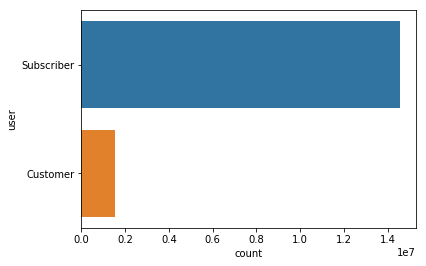

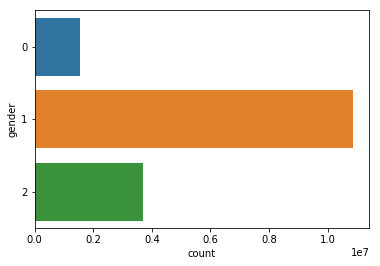

In [36]:
# categorical data split 
for feature in ['user', 'gender']:
    sns.countplot(data=citibike_outlier_removed, y=feature)
    plt.show()

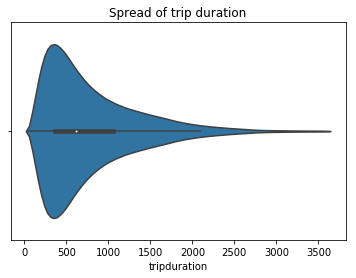

In [37]:
## trying to see the skew of the tripduration
sns.violinplot(citibike_outlier_removed['tripduration'])
plt.title('Spread of trip duration')
plt.show()

In [38]:
# Number of individual bikes
citibike_outlier_removed['bikeid'].unique().shape 

(14174,)

In [39]:
# Number of citibike stations
citibike_outlier_removed['startstationid'].unique().shape 

(807,)

In [40]:
# Dropping columns to smaller the dataframe
del citibike_outlier_removed['index']

### Step 4 : Creating visulaization as required in the capstone

#### Chart 1 : Top 5 stations with the most starts (showing # of starts) 

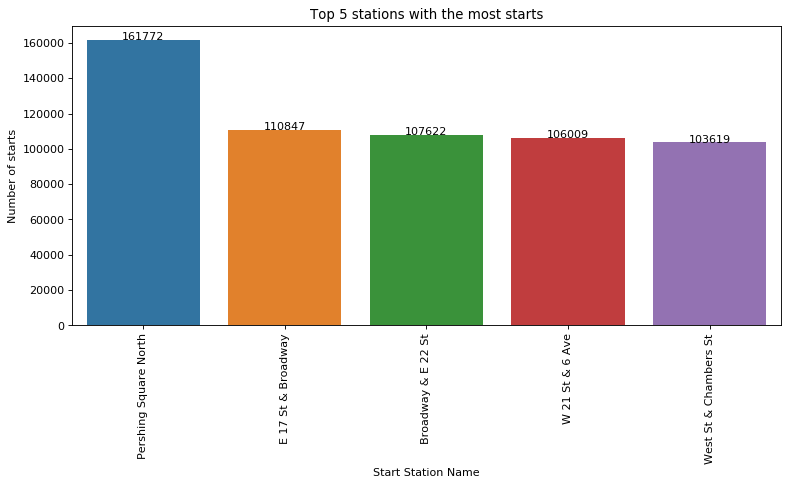

In [41]:
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.countplot(data=citibike_outlier_removed, 
              x='startstationname',order=citibike_outlier_removed.startstationname.value_counts().iloc[:5].index)
plt.xticks(rotation=90)
plt.tight_layout()
plt.title('Top 5 stations with the most starts')
plt.ylabel('Number of starts')
plt.xlabel('Start Station Name')
for p in ax.patches:
        ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+50))
plt.show()

#### Chart 2 : Trip duration by user type

Text(0.5,1,'Spread of trip duration by user type')

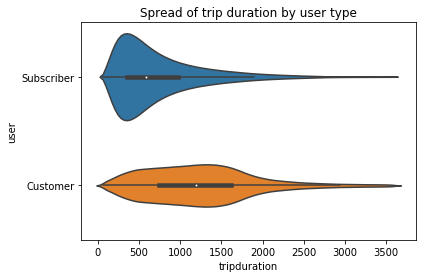

In [42]:
sns.violinplot(x="tripduration", y="user", data=citibike_outlier_removed)
plt.title('Spread of trip duration by user type')

#### Chart 3 : Most popular trips based on start station and stop station)

In [43]:
### creating a grouped version of df for creating this visual
start_end_pairs = citibike_outlier_removed.groupby(['startstationname','endstationname'])[['bikeid']].count().reset_index()

In [44]:
start_end_pairs = start_end_pairs.sort_values('bikeid',ascending=False)

In [45]:
start_end_pairs.rename(columns={'bikeid': 'count'}, inplace=True)

In [46]:
start_end_pairs[:10]

,startstationname,endstationname,count
72754,Central Park S & 6 Ave,5 Ave & E 88 St,6218
138474,E 7 St & Avenue A,Cooper Square & E 7 St,5956
72827,Central Park S & 6 Ave,Central Park S & 6 Ave,5685
7742,12 Ave & W 40 St,West St & Chambers St,5360
263184,W 21 St & 6 Ave,9 Ave & W 22 St,4782
219903,Pershing Square North,Broadway & W 32 St,4517
220037,Pershing Square North,E 24 St & Park Ave S,4392
76126,Centre St & Chambers St,Centre St & Chambers St,4296
296235,West St & Chambers St,12 Ave & W 40 St,4283
220370,Pershing Square North,W 33 St & 7 Ave,4243


#### Chart 5 :  What is the busiest bike in NYC in 2017? How many times was it used? How many minutes was it in use?

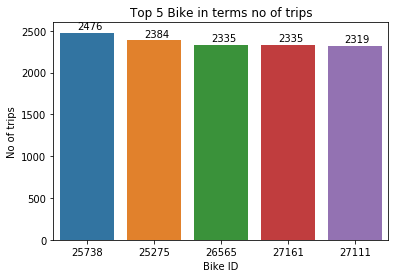

In [47]:
ax = sns.countplot(data=citibike_outlier_removed, x='bikeid',
              order=citibike_outlier_removed.bikeid.value_counts().iloc[:5].index)
plt.title('Top 5 Bike in terms no of trips')
plt.ylabel('No of trips')
plt.xlabel('Bike ID')
for p in ax.patches:
        ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+40))
plt.show()

In [48]:
### creating a grouped version of df for creating this visual
busy_bike = citibike_outlier_removed.groupby('bikeid').agg({'gender':'count', 'tripduration': 'sum'}).reset_index().rename(columns={'gender':'Count'})

In [49]:
busy_bike = busy_bike.sort_values('tripduration',ascending=False)

In [50]:
data_for_plot=busy_bike[:5]
data_for_plot

,bikeid,Count,tripduration
7064,25738,2476,1959141
8468,27263,2257,1870977
6611,25275,2384,1843536
8316,27111,2319,1832347
8139,26931,2279,1826881


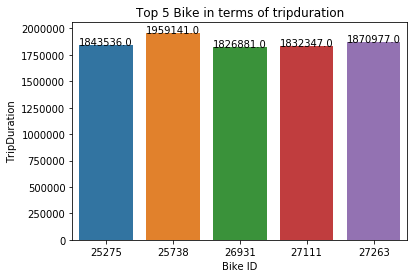

In [51]:
ax = sns.barplot(x="bikeid", y="tripduration", data=data_for_plot)
plt.title('Top 5 Bike in terms of tripduration')
plt.ylabel('TripDuration')
plt.xlabel('Bike ID')
for p in ax.patches:
        ax.annotate('{:}'.format(p.get_height()), (p.get_x(), p.get_height()))
plt.show()

#### The busiest bike was bike number 25738. It was used 2451 times and was in use for 1,935,015 seconds.

In [52]:
citibike_outlier_removed.tail(5)

,bikeid,endstationid,endstationlatitude,endstationlongitude,endstationname,gender,startstationid,startstationlatitude,startstationlongitude,startstationname,starttime,stoptime,tripduration,distance,speed,user,Age
16364652,30841,3418,40.675021,-73.971115,Plaza St West & Flatbush Ave,2,3417,40.679577,-73.978550,Baltic St & 5 Ave,2017-12-31 23:54:22,2018-01-01 00:01:00,397,0.806071,7.309456,Subscriber,61.0
16364653,30417,513,40.768254,-73.988639,W 56 St & 10 Ave,1,3236,40.758985,-73.993800,W 42 St & Dyer Ave,2017-12-31 23:54:44,2018-01-01 00:00:16,332,1.118580,12.129180,Subscriber,34.0
16364654,16125,411,40.722281,-73.976687,E 6 St & Avenue D,1,254,40.735324,-73.998004,W 11 St & 6 Ave,2017-12-31 23:56:07,2018-01-01 00:05:33,565,2.308707,14.710343,Subscriber,27.0
16364655,33328,3163,40.773407,-73.977825,Central Park West & W 68 St,2,495,40.762699,-73.993012,W 47 St & 10 Ave,2017-12-31 23:57:16,2018-01-01 00:24:56,1659,1.747387,3.791797,Subscriber,30.0
16364656,31023,3143,40.776321,-73.964274,5 Ave & E 78 St,2,3135,40.771129,-73.957723,E 75 St & 3 Ave,2017-12-31 23:58:56,2018-01-01 00:20:16,1279,0.798516,2.247582,Subscriber,50.0


#### Chart 4 : Rider performance by Gender and Age based on avg trip distance (station to station), median speed (trip duration / distance traveled) 

In [53]:
### creating a grouped version of df for creating this visual
dist_age_gend = citibike_outlier_removed.groupby(['gender','Age'])[['distance']].mean().reset_index()

In [54]:
dist_age_gend = dist_age_gend.sort_values('Age')

In [55]:
dist_age_gend_sub = dist_age_gend[dist_age_gend['gender']>0]

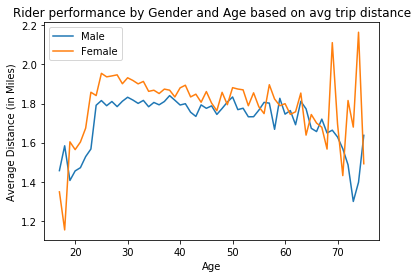

In [56]:
fig, ax = plt.subplots()

for key, grp in dist_age_gend_sub.groupby(['gender']):
    ax = grp.plot(ax=ax, kind='line', x='Age', y='distance', label=key)

L = plt.legend(loc='best')
L.get_texts()[0].set_text('Male')
L.get_texts()[1].set_text('Female')
plt.title('Rider performance by Gender and Age based on avg trip distance')
plt.ylabel('Average Distance (in Miles)')
plt.show()

In [57]:
### creating a grouped version of df for creating this visual
speed_age_gend = citibike_outlier_removed.groupby(['gender','Age'])[['speed']].mean().reset_index()

In [58]:
speed_age_gend = speed_age_gend.sort_values('Age')

In [59]:
speed_age_gend_sub = speed_age_gend[speed_age_gend['gender']>0]

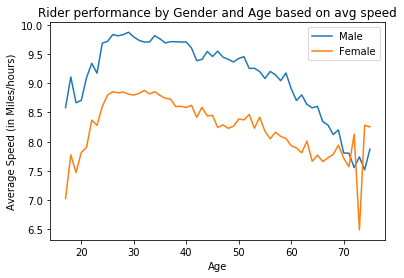

In [60]:
fig, ax = plt.subplots()

for key, grp in speed_age_gend_sub.groupby(['gender']):
    ax = grp.plot(ax=ax, kind='line', x='Age', y='speed', label=key)
L = plt.legend(loc='best')
L.get_texts()[0].set_text('Male')
L.get_texts()[1].set_text('Female')
plt.title('Rider performance by Gender and Age based on avg speed')
plt.ylabel('Average Speed (in Miles/hours)')
plt.show()

In [61]:
# Dropping columns to smaller the dataframe
del citibike_outlier_removed['bikeid']
del citibike_outlier_removed['endstationname']
del citibike_outlier_removed['startstationname']
del citibike_outlier_removed['stoptime']
del citibike_outlier_removed['endstationlongitude']
del citibike_outlier_removed['endstationlatitude']
del citibike_outlier_removed['startstationlatitude']
del citibike_outlier_removed['startstationlongitude']

In [62]:
# making a pkl file to import further as it is faster to load
citibike_outlier_removed.to_pickle('model.pkl')

## Section 4 : Modelling Phase

#### Step 1: Prepping the data for modelling

In [2]:
file_name = 'model.pkl'
%time citibike_outlier_removed = pd.read_pickle(file_name)

CPU times: user 2.19 s, sys: 1.93 s, total: 4.12 s
Wall time: 4.31 s


In [3]:
citibike_outlier_removed.head(5)

,endstationid,gender,startstationid,starttime,tripduration,distance,speed,user,Age
0,3165,2,3226,2017-01-01 00:00:21,680,0.874120,4.627697,Subscriber,53.0
1,498,2,3263,2017-01-01 00:00:45,1282,2.160181,6.066030,Subscriber,31.0
2,3152,0,3143,2017-01-01 00:00:57,648,0.927803,5.154461,Customer,0.0
3,3152,0,3143,2017-01-01 00:01:10,631,0.927803,5.293329,Customer,0.0
4,3152,0,3143,2017-01-01 00:01:25,621,0.927803,5.378568,Customer,0.0


In [4]:
citibike_outlier_removed['dow']= pd.to_datetime(citibike_outlier_removed['starttime']).dt.dayofweek
citibike_outlier_removed['date']= pd.to_datetime(citibike_outlier_removed['starttime']).dt.date
citibike_outlier_removed['month']= pd.to_datetime(citibike_outlier_removed['starttime']).dt.month
citibike_outlier_removed['hour']= pd.to_datetime(citibike_outlier_removed['starttime']).dt.hour

In [5]:
## Loading the weather data
weather = pd.read_csv('./Downloads/Weather.csv')

In [6]:
weather['date']= pd.to_datetime(weather['Date']).dt.date

In [7]:
# Dropping columns to smaller the dataframe
del weather['Date']

In [8]:
temp = citibike_outlier_removed[['hour', 'user']].copy()

In [9]:
temp.groupby(['user','hour'])['hour'].count()

user        hour
Customer    0         13982
            1          8120
            2          4847
            3          2876
            4          1948
            5          2504
            6          7014
            7         17323
            8         38088
            9         55396
            10        81203
            11       109687
            12       127698
            13       136375
            14       144440
            15       149240
            16       147757
            17       140358
            18       116843
            19        84415
            20        57136
            21        40439
            22        32520
            23        22234
Subscriber  0        125823
            1         68595
            2         38546
            3         23604
            4         24581
            5         96206
            6        348314
            7        726822
            8       1263705
            9        964374
            10       635858
   

In [10]:
temp2 = citibike_outlier_removed[['dow', 'user']].copy()

In [11]:
temp2.groupby(['user','dow'])['dow'].count()

user        dow
Customer    0       177864
            1       156905
            2       161071
            3       169047
            4       187561
            5       342196
            6       347799
Subscriber  0      2104834
            1      2254321
            2      2485506
            3      2370563
            4      2169225
            5      1605641
            6      1573386
Name: dow, dtype: int64

In [12]:
temp3 = citibike_outlier_removed[['month', 'user']].copy()

In [13]:
temp3.groupby(['user','month'])['month'].count()

user        month
Customer    1          27772
            2          46877
            3          31379
            4         158103
            5         163113
            6         181911
            7         215125
            8         212883
            9         196579
            10        185694
            11         85158
            12         37849
Subscriber  1         691254
            2         735340
            3         688412
            4        1133390
            5        1335871
            6        1520515
            7        1487255
            8        1571367
            9        1650258
            10       1681510
            11       1226776
            12        841528
Name: month, dtype: int64

In [14]:
## Merging the data with weather to get weather data
merged_data = pd.merge(citibike_outlier_removed, weather, how='left', on='date', validate=None)

In [15]:
# Dropping columns to smaller the dataframe
del merged_data['starttime']
del merged_data['date']

In [16]:
merged_data.head()

,endstationid,gender,startstationid,tripduration,distance,speed,user,Age,dow,month,...,Temp_avg,DP_avg,Humid_avg,Sea_avg,Vis_avg,Wind_avg,Precip,Snow,Rain,Fog
0,3165,2,3226,680,0.874120,4.627697,Subscriber,53.0,6,1,...,44,22,41,30.17,10,5,0.0,0,0,0
1,498,2,3263,1282,2.160181,6.066030,Subscriber,31.0,6,1,...,44,22,41,30.17,10,5,0.0,0,0,0
2,3152,0,3143,648,0.927803,5.154461,Customer,0.0,6,1,...,44,22,41,30.17,10,5,0.0,0,0,0
3,3152,0,3143,631,0.927803,5.293329,Customer,0.0,6,1,...,44,22,41,30.17,10,5,0.0,0,0,0
4,3152,0,3143,621,0.927803,5.378568,Customer,0.0,6,1,...,44,22,41,30.17,10,5,0.0,0,0,0


In [17]:
sub = merged_data[merged_data['user'] == 'Subscriber']

In [18]:
cus = merged_data[merged_data['user'] == 'Customer']

In [19]:
Speed_sub = sub.groupby(['startstationid','Age','gender','endstationid'])[['speed']].mean().reset_index()

In [20]:
Speed_cus = cus.groupby(['startstationid','endstationid'])[['speed']].mean().reset_index()

#### Step 2: Creating some features absed on above analysis

In [21]:
merged_data['peak'] = ((((merged_data.hour >= 7) & (merged_data.user == "Subscriber")) & 
                ((merged_data.hour < 21) & (merged_data.user == "Subscriber"))) |
                (((merged_data.hour >= 10) & (merged_data.user == "Customer")) & 
                 ((merged_data.hour < 20) & (merged_data.user == "Customer"))))

In [22]:
merged_data['seasonal'] = ((((merged_data.month >= 4) & (merged_data.user == "Subscriber")) & 
                ((merged_data.month < 12) & (merged_data.user == "Subscriber"))) |
                (((merged_data.month >= 4) & (merged_data.user == "Customer")) & 
                 ((merged_data.month < 11) & (merged_data.user == "Customer"))))

In [23]:
merged_data['weekly'] = ((((merged_data.dow >= 0) & (merged_data.user == "Subscriber")) & 
                ((merged_data.dow < 5) & (merged_data.user == "Subscriber"))) |
                (((merged_data.dow >= 5) & (merged_data.user == "Customer")) & 
                 ((merged_data.dow <= 6) & (merged_data.user == "Customer"))))

In [24]:
merged_data.head()

,endstationid,gender,startstationid,tripduration,distance,speed,user,Age,dow,month,...,Sea_avg,Vis_avg,Wind_avg,Precip,Snow,Rain,Fog,peak,seasonal,weekly
0,3165,2,3226,680,0.874120,4.627697,Subscriber,53.0,6,1,...,30.17,10,5,0.0,0,0,0,False,False,False
1,498,2,3263,1282,2.160181,6.066030,Subscriber,31.0,6,1,...,30.17,10,5,0.0,0,0,0,False,False,False
2,3152,0,3143,648,0.927803,5.154461,Customer,0.0,6,1,...,30.17,10,5,0.0,0,0,0,False,False,True
3,3152,0,3143,631,0.927803,5.293329,Customer,0.0,6,1,...,30.17,10,5,0.0,0,0,0,False,False,True
4,3152,0,3143,621,0.927803,5.378568,Customer,0.0,6,1,...,30.17,10,5,0.0,0,0,0,False,False,True


In [25]:
# Summary of the numerical variables
merged_data.describe()

,endstationid,gender,startstationid,tripduration,distance,speed,Age,dow,month,hour,Temp_avg,DP_avg,Humid_avg,Sea_avg,Vis_avg,Wind_avg,Precip,Snow,Rain,Fog
count,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07,1.610592e+07
mean,1.344312e+03,1.133015e+00,1.353253e+03,7.871790e+02,1.812898e+00,8.982541e+00,3.525572e+01,2.857127e+00,7.064875e+00,1.391521e+01,6.226345e+01,4.793811e+01,6.312289e+01,3.002037e+01,9.117255e+00,4.771993e+00,7.324358e-02,1.315672e-02,2.675888e-01,4.231916e-02
std,1.343160e+03,5.539790e-01,1.345613e+03,5.684718e+02,1.385993e+00,3.225441e+00,1.589762e+01,1.929242e+00,3.002168e+00,4.844868e+00,1.452585e+01,1.621059e+01,1.377039e+01,2.027685e-01,1.604226e+00,2.040530e+00,2.503365e-01,1.139457e-01,4.427020e-01,2.013163e-01
min,7.200000e+01,0.000000e+00,7.200000e+01,6.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.500000e+01,-7.000000e+00,2.600000e+01,2.938000e+01,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.590000e+02,1.000000e+00,3.610000e+02,3.700000e+02,8.620009e-01,7.203845e+00,2.800000e+01,1.000000e+00,5.000000e+00,1.000000e+01,5.100000e+01,3.700000e+01,5.200000e+01,2.991000e+01,9.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.860000e+02,1.000000e+00,4.870000e+02,6.150000e+02,1.418342e+00,9.141423e+00,3.500000e+01,3.000000e+00,7.000000e+00,1.500000e+01,6.500000e+01,5.100000e+01,6.300000e+01,3.000000e+01,1.000000e+01,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.140000e+03,1.000000e+00,3.141000e+03,1.057000e+03,2.349239e+00,1.103253e+01,4.600000e+01,4.000000e+00,1.000000e+01,1.800000e+01,7.500000e+01,6.100000e+01,7.300000e+01,3.014000e+01,1.000000e+01,6.000000e+00,1.000000e-02,0.000000e+00,1.000000e+00,0.000000e+00
max,3.654000e+03,2.000000e+00,3.654000e+03,3.600000e+03,9.999956e+00,2.429398e+02,7.500000e+01,6.000000e+00,1.200000e+01,2.300000e+01,8.600000e+01,7.300000e+01,9.800000e+01,3.068000e+01,1.000000e+01,1.800000e+01,3.030000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [26]:
## Dropping rows having distance = 0 as you can't predict time for a journey having distance 0.
modelling = merged_data[merged_data.distance != 0]

In [27]:
### converting boolean variables into integers
modelling['peak'] = modelling['peak'].astype(int)
modelling['seasonal'] = modelling['seasonal'].astype(int)
modelling['weekly'] = modelling['weekly'].astype(int)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [28]:
## As it is really hard to drive less than 5 mph (considering Avg. Human Walking speed of 3.5 mph) and
## As it is really hard to drive more than 20 mph (considering driving in manhattan has a lot of signals 
## and turns which bring in waiitng time so average speed decreases)
modelling = modelling[modelling.speed >= 5]
modelling = modelling[modelling.speed <= 20]

In [29]:
# Summary of the numerical variables
modelling.describe()

,endstationid,gender,startstationid,tripduration,distance,speed,Age,dow,month,hour,...,Sea_avg,Vis_avg,Wind_avg,Precip,Snow,Rain,Fog,peak,seasonal,weekly
count,1.444125e+07,1.444125e+07,1.444125e+07,1.444125e+07,1.444125e+07,1.444125e+07,1.444125e+07,1.444125e+07,1.444125e+07,1.444125e+07,...,1.444125e+07,1.444125e+07,1.444125e+07,1.444125e+07,1.444125e+07,1.444125e+07,1.444125e+07,1.444125e+07,1.444125e+07,1.444125e+07
mean,1.325930e+03,1.165773e+00,1.337081e+03,7.283071e+02,1.912239e+00,9.696844e+00,3.630713e+01,2.801431e+00,7.057237e+00,1.384253e+01,...,3.002039e+01,9.115758e+00,4.797535e+00,7.351960e-02,1.371641e-02,2.681568e-01,4.193447e-02,8.731510e-01,7.961805e-01,7.669455e-01
std,1.336590e+03,5.217934e-01,1.339983e+03,5.108167e+02,1.404345e+00,2.485336e+00,1.475709e+01,1.908355e+00,3.035876e+00,4.902611e+00,...,2.040765e-01,1.610116e+00,2.057960e+00,2.511440e-01,1.163111e-01,4.429997e-01,2.004395e-01,3.328037e-01,4.028363e-01,4.227767e-01
min,7.200000e+01,0.000000e+00,7.200000e+01,6.100000e+01,8.625407e-02,5.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,...,2.938000e+01,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.590000e+02,1.000000e+00,3.610000e+02,3.560000e+02,9.235726e-01,7.880538e+00,2.900000e+01,1.000000e+00,5.000000e+00,9.000000e+00,...,2.991000e+01,9.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
50%,4.850000e+02,1.000000e+00,4.860000e+02,5.770000e+02,1.490642e+00,9.499315e+00,3.500000e+01,3.000000e+00,7.000000e+00,1.500000e+01,...,3.001000e+01,1.000000e+01,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
75%,3.136000e+03,1.000000e+00,3.140000e+03,9.630000e+02,2.467305e+00,1.126982e+01,4.600000e+01,4.000000e+00,1.000000e+01,1.800000e+01,...,3.014000e+01,1.000000e+01,6.000000e+00,1.000000e-02,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
max,3.654000e+03,2.000000e+00,3.654000e+03,3.600000e+03,9.999956e+00,1.999950e+01,7.500000e+01,6.000000e+00,1.200000e+01,2.300000e+01,...,3.068000e+01,1.000000e+01,1.800000e+01,3.030000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [30]:
modelling.head(5)

,endstationid,gender,startstationid,tripduration,distance,speed,user,Age,dow,month,...,Sea_avg,Vis_avg,Wind_avg,Precip,Snow,Rain,Fog,peak,seasonal,weekly
1,498,2,3263,1282,2.160181,6.066030,Subscriber,31.0,6,1,...,30.17,10,5,0.0,0,0,0,0,0,0
2,3152,0,3143,648,0.927803,5.154461,Customer,0.0,6,1,...,30.17,10,5,0.0,0,0,0,0,0,1
3,3152,0,3143,631,0.927803,5.293329,Customer,0.0,6,1,...,30.17,10,5,0.0,0,0,0,0,0,1
4,3152,0,3143,621,0.927803,5.378568,Customer,0.0,6,1,...,30.17,10,5,0.0,0,0,0,0,0,1
6,479,1,499,559,1.269446,8.175325,Subscriber,45.0,6,1,...,30.17,10,5,0.0,0,0,0,0,0,0


In [31]:
# Dropping columns to smaller the dataframe
del modelling['dow']
del modelling['month']
del modelling['hour']

In [32]:
### Creating two different models for subscribers and customers as they have different behaviour.
modelling_sub = modelling.loc[modelling['user'] == 'Subscriber']
modelling_cus = modelling.loc[modelling['user'] == 'Customer']

#### Step 3: Creating Linear Regression Model for Subscriber

In [33]:
# Dropping columns to smaller the dataframe
del modelling_sub['user']

In [34]:
modelling_sub1 = pd.merge(modelling_sub, Speed_sub, how='left', on=['startstationid','Age','gender','endstationid'], 
                         validate=None)

In [35]:
del modelling_sub1['endstationid']
del modelling_sub1['startstationid']

In [36]:
# Summary of the numerical variables
modelling_sub1.describe()

,gender,tripduration,distance,speed_x,Age,Temp_avg,DP_avg,Humid_avg,Sea_avg,Vis_avg,Wind_avg,Precip,Snow,Rain,Fog,peak,seasonal,weekly,speed_y
count,1.347404e+07,1.347404e+07,1.347404e+07,1.347404e+07,1.347404e+07,1.347404e+07,1.347404e+07,1.347404e+07,1.347404e+07,1.347404e+07,1.347404e+07,1.347404e+07,1.347404e+07,1.347404e+07,1.347404e+07,1.347404e+07,1.347404e+07,1.347404e+07,1.347404e+07
mean,1.249456e+00,7.016880e+02,1.877260e+00,9.810315e+00,3.891335e+01,6.166208e+01,4.739923e+01,6.315910e+01,3.002037e+01,9.113290e+00,4.819921e+00,7.391034e-02,1.436547e-02,2.687608e-01,4.177818e-02,8.800940e-01,7.929379e-01,7.905818e-01,9.647308e+00
std,4.327298e-01,4.944124e+02,1.400468e+00,2.458818e+00,1.148856e+01,1.475340e+01,1.643311e+01,1.381794e+01,2.050759e-01,1.616726e+00,2.074250e+00,2.522982e-01,1.189921e-01,4.433153e-01,2.000819e-01,3.248516e-01,4.052004e-01,4.068934e-01,2.081103e+00
min,0.000000e+00,6.100000e+01,8.625407e-02,5.000000e+00,1.700000e+01,1.500000e+01,-7.000000e+00,2.600000e+01,2.938000e+01,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.862916e-01
25%,1.000000e+00,3.470000e+02,9.064279e-01,8.027817e+00,3.000000e+01,5.000000e+01,3.600000e+01,5.200000e+01,2.990000e+01,9.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,8.224465e+00
50%,1.000000e+00,5.560000e+02,1.451072e+00,9.611875e+00,3.600000e+01,6.400000e+01,5.100000e+01,6.300000e+01,3.001000e+01,1.000000e+01,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.516319e+00
75%,1.000000e+00,9.140000e+02,2.399964e+00,1.135847e+01,4.700000e+01,7.400000e+01,6.100000e+01,7.300000e+01,3.014000e+01,1.000000e+01,6.000000e+00,1.000000e-02,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.093296e+01
max,2.000000e+00,3.600000e+03,9.999956e+00,1.999950e+01,7.500000e+01,8.600000e+01,7.300000e+01,9.800000e+01,3.068000e+01,1.000000e+01,1.800000e+01,3.030000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.863405e+01


In [37]:
modelling_sub1.corr()

,gender,tripduration,distance,speed_x,Age,Temp_avg,DP_avg,Humid_avg,Sea_avg,Vis_avg,Wind_avg,Precip,Snow,Rain,Fog,peak,seasonal,weekly,speed_y
gender,1.000000,0.094063,0.032244,-0.161026,-0.054069,0.031738,0.027143,0.000970,0.003710,0.006825,-0.021752,-0.006563,-0.010889,-0.004067,-0.002013,0.034323,0.029888,-0.042418,-0.180968
tripduration,0.094063,1.000000,0.907586,-0.103355,0.014577,0.083960,0.068366,-0.005006,-0.001264,0.020419,-0.051184,-0.021459,-0.022826,-0.016588,-0.012394,0.038883,0.068659,-0.026412,0.043891
distance,0.032244,0.907586,1.000000,0.244425,-0.007521,0.071103,0.057803,-0.003785,-0.002038,0.018653,-0.042803,-0.018537,-0.022398,-0.013076,-0.012823,0.017699,0.057987,0.003874,0.340242
speed_x,-0.161026,-0.103355,0.244425,1.000000,-0.088912,-0.031281,-0.027466,-0.000149,-0.002411,-0.005202,0.021852,0.008680,-0.002262,0.009135,-0.000607,-0.072291,-0.023902,0.054680,0.786841
Age,-0.054069,0.014577,-0.007521,-0.088912,1.000000,-0.049323,-0.047503,-0.013504,-0.006107,-0.000545,0.030332,-0.001986,0.012855,-0.003123,0.000155,0.049025,-0.052768,0.053318,-0.101714
Temp_avg,0.031738,0.083960,0.071103,-0.031281,-0.049323,1.000000,0.920803,0.201220,-0.146672,0.012170,-0.471907,0.006577,-0.247674,0.065337,-0.013978,-0.016655,0.689933,-0.003453,-0.014638
DP_avg,0.027143,0.068366,0.057803,-0.027466,-0.047503,0.920803,1.000000,0.552138,-0.213828,-0.227354,-0.457860,0.151403,-0.181762,0.249053,0.073917,-0.018923,0.649317,0.003208,-0.012589
Humid_avg,0.000970,-0.005006,-0.003785,-0.000149,-0.013504,0.201220,0.552138,1.000000,-0.241004,-0.636380,-0.117868,0.367913,0.020420,0.510244,0.217207,-0.011293,0.167628,0.012302,0.000583
Sea_avg,0.003710,-0.001264,-0.002038,-0.002411,-0.006107,-0.146672,-0.213828,-0.241004,1.000000,0.253276,-0.224462,-0.220691,-0.085040,-0.256059,-0.142129,0.005307,0.009716,-0.031178,-0.004398
Vis_avg,0.006825,0.020419,0.018653,-0.005202,-0.000545,0.012170,-0.227354,-0.636380,0.253276,1.000000,0.024335,-0.528530,-0.211199,-0.474332,-0.442775,0.012724,0.038201,0.067159,-0.002912


In [38]:
### Dropping columns to smaller the dataframe based on correlation being very less with trip duration and 
del modelling_sub1['speed_x']
del modelling_sub1['Sea_avg']
del modelling_sub1['Humid_avg']
### DP_Avg as it is highly correalted to temperature
del modelling_sub1['DP_avg']

In [39]:
## Scaling all the variables to have zero mean and one standard deviation
scaler = MinMaxScaler()
modelling_sub1[['Age', 'distance','Temp_avg','Vis_avg','Wind_avg','Precip','speed_y']] = scaler.fit_transform(modelling_sub1[['Age','distance',
                                                                                          'Temp_avg','Vis_avg'
                                                                                          ,'Wind_avg','Precip','speed_y']])

In [40]:
suby = modelling_sub1['tripduration']
subX = modelling_sub1.drop('tripduration', axis=1)
sub_X_train, sub_X_test, sub_y_train, sub_y_test = train_test_split(subX, suby, test_size=0.33, random_state=42)

In [41]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(sub_X_train, sub_y_train)

# Make predictions using the testing set
sub_y_pred = regr.predict(sub_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The Intercept
print('Intercept: \n', regr.intercept_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(sub_y_test, sub_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(sub_y_test, sub_y_pred))

Coefficients: 
 [ 7.42589080e+00  3.52702576e+03 -1.76454352e+01  2.09897031e+01
  9.16198966e-01  1.84806112e+00 -1.78130949e+00  1.09463735e+01
 -2.43587205e+00 -1.71761428e+00  8.61312479e+00 -6.45469161e-01
 -1.50211359e+01 -1.98789403e+03]
Intercept: 
 699.285711129611
Mean squared error: 23621.18
Variance score: 0.90


In [42]:
X2 = sm.add_constant(sub_X_train)
est = sm.OLS(sub_y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           tripduration   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                 6.034e+06
Date:                Mon, 30 Apr 2018   Prob (F-statistic):               0.00
Time:                        21:55:47   Log-Likelihood:            -5.8258e+07
No. Observations:             9027608   AIC:                         1.165e+08
Df Residuals:                 9027593   BIC:                         1.165e+08
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        699.2857      0.514   1359.593      0.0

In [43]:
# Create SGD linear regression object
clf = linear_model.SGDRegressor()
# Train the model using the training sets
clf.fit(sub_X_train, sub_y_train)
# Make predictions using the testing set
sub_y_pred = clf.predict(sub_X_test)
# The coefficients
print('Coefficients: \n', clf.coef_)
# The Intercept
print('Intercept: \n', clf.intercept_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(sub_y_test, sub_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(sub_y_test, sub_y_pred))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Coefficients: 
 [ 8.98329657e+00  3.49995420e+03 -1.49801300e+01  2.18814375e+01
  1.46732111e+00  1.62566096e+00 -1.30730749e+00  1.08660279e+01
 -1.05674308e+00  5.28156442e-01  9.58763336e+00 -3.55710067e-01
 -1.43150470e+01 -1.93126032e+03]
Intercept: 
 [682.14166507]
Mean squared error: 23651.23
Variance score: 0.90


In [44]:
# Create Ridge linear regression object
clf = linear_model.Ridge(alpha = .5)
# Train the model using the training sets
clf.fit(sub_X_train, sub_y_train)
# Make predictions using the testing set
sub_y_pred = clf.predict(sub_X_test)
# The coefficients
print('Coefficients: \n', clf.coef_)
# The Intercept
print('Intercept: \n', clf.intercept_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(sub_y_test, sub_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(sub_y_test, sub_y_pred))

Coefficients: 
 [ 7.42704413e+00  3.52701001e+03 -1.76440849e+01  2.09903204e+01
  9.16309157e-01  1.84784254e+00 -1.78165630e+00  1.09463236e+01
 -2.43592606e+00 -1.71754627e+00  8.61354759e+00 -6.45304174e-01
 -1.50214362e+01 -1.98786183e+03]
Intercept: 
 699.2754274741244
Mean squared error: 23621.19
Variance score: 0.90


In [45]:
# Create linear regression object
clf = linear_model.Lasso(alpha = 0.1)
# Train the model using the training sets
clf.fit(sub_X_train, sub_y_train)
# Make predictions using the testing set
sub_y_pred = clf.predict(sub_X_test)
# The coefficients
print('Coefficients: \n', clf.coef_)
# The Intercept
print('Intercept: \n', clf.intercept_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(sub_y_test, sub_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(sub_y_test, sub_y_pred))

Coefficients: 
 [ 7.93073383e+00  3.51759960e+03 -1.41437988e+01  1.66354933e+01
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  9.44340258e-01
 -2.56092150e+00 -0.00000000e+00  7.89171062e+00  0.00000000e+00
 -1.46067341e+01 -1.96235978e+03]
Intercept: 
 694.658647184429
Mean squared error: 23627.52
Variance score: 0.90


In [46]:
sub_X_train.head(1)

,gender,distance,Age,Temp_avg,Vis_avg,Wind_avg,Precip,Snow,Rain,Fog,peak,seasonal,weekly,speed_y
4729643,2,0.116109,0.655172,0.859155,1.0,0.176471,0.0,0,0,0,1,1,0,0.246225


In [47]:
### Dropping columns to smaller the dataframe based on that lasso gave them zero for their coeff
del modelling_sub1['Vis_avg']
del modelling_sub1['Wind_avg']
del modelling_sub1['Precip']
del modelling_sub1['Fog']
del modelling_sub1['seasonal']

In [48]:
suby = modelling_sub1['tripduration']
subX = modelling_sub1.drop('tripduration', axis=1)
sub_X_train, sub_X_test, sub_y_train, sub_y_test = train_test_split(subX, suby, test_size=0.33, random_state=42)

In [49]:
# Create linear regression object
clf = linear_model.Lasso(alpha = 0.1)
# Train the model using the training sets
clf.fit(sub_X_train, sub_y_train)
# Make predictions using the testing set
sub_y_pred = clf.predict(sub_X_test)
# The coefficients
print('Coefficients: \n', clf.coef_)
# The Intercept
print('Intercept: \n', clf.intercept_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(sub_y_test, sub_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(sub_y_test, sub_y_pred))

Coefficients: 
 [ 7.91698390e+00  3.51764197e+03 -1.41509585e+01  1.66261281e+01
  9.42392346e-01 -2.56026725e+00  7.88839723e+00 -1.46040887e+01
 -1.96240583e+03]
Intercept: 
 694.6926935473928
Mean squared error: 23627.51
Variance score: 0.90


In [50]:
sub_X_train.head(1)

,gender,distance,Age,Temp_avg,Snow,Rain,peak,weekly,speed_y
4729643,2,0.116109,0.655172,0.859155,0,0,1,0,0.246225


In [51]:
scores = cross_val_score(clf, subX, suby, scoring="neg_mean_squared_error", cv=5)
mse_scores =-scores
scores = cross_val_score(clf, subX, suby, scoring="r2", cv=5)
r2_scores =scores
r2_scores.mean()

0.903036122839098

In [52]:
mse_scores.mean()

23656.567163777687

#### Step 4: Creating Linear Regression Model for Customers

In [53]:
# Dropping columns to smaller the dataframe
del modelling_cus['gender']
del modelling_cus['user']
del modelling_cus['Age']

In [54]:
modelling_cus1 = pd.merge(modelling_cus, Speed_cus, how='left', on=['startstationid','endstationid'], 
                         validate=None)

In [55]:
del modelling_cus1['endstationid']
del modelling_cus1['startstationid']

In [56]:
modelling_cus1.corr()

,tripduration,distance,speed_x,Temp_avg,DP_avg,Humid_avg,Sea_avg,Vis_avg,Wind_avg,Precip,Snow,Rain,Fog,peak,seasonal,weekly,speed_y
tripduration,1.000000,0.849245,-0.208833,0.090151,0.062478,-0.018732,-0.005258,0.009814,-0.047961,-0.014491,-0.033337,-0.013352,-0.003178,0.114702,0.090730,0.101922,0.290261
distance,0.849245,1.000000,0.268110,0.075842,0.053906,-0.013651,-0.005219,0.008764,-0.040749,-0.011588,-0.026385,-0.010785,-0.003622,0.058954,0.074005,0.068872,0.586316
speed_x,-0.208833,0.268110,1.000000,-0.051804,-0.037172,0.007325,0.001207,-0.002352,0.026333,0.007854,0.019700,0.006078,-0.001832,-0.126792,-0.054733,-0.075068,0.596162
Temp_avg,0.090151,0.075842,-0.051804,1.000000,0.896079,0.191446,-0.196500,-0.062414,-0.431925,0.047928,-0.192158,0.042582,0.054791,-0.002427,0.713435,0.044969,-0.011170
DP_avg,0.062478,0.053906,-0.037172,0.896079,1.000000,0.591301,-0.279054,-0.324895,-0.414937,0.187237,-0.136145,0.234910,0.149977,-0.012686,0.614735,0.037096,-0.010266
Humid_avg,-0.018732,-0.013651,0.007325,0.191446,0.591301,1.000000,-0.269116,-0.645859,-0.129932,0.309538,0.016066,0.447785,0.231832,-0.020335,0.110525,0.003142,-0.003845
Sea_avg,-0.005258,-0.005219,0.001207,-0.196500,-0.279054,-0.269116,1.000000,0.264171,-0.174196,-0.238022,-0.043149,-0.294278,-0.191573,0.009338,-0.079758,-0.000881,0.001693
Vis_avg,0.009814,0.008764,-0.002352,-0.062414,-0.324895,-0.645859,0.264171,1.000000,0.069210,-0.468582,-0.122554,-0.420025,-0.425203,0.006356,-0.048382,-0.092803,0.003491
Wind_avg,-0.047961,-0.040749,0.026333,-0.431925,-0.414937,-0.129932,-0.174196,0.069210,1.000000,0.072088,0.062179,0.099572,-0.009434,0.000205,-0.327861,-0.027683,0.004154
Precip,-0.014491,-0.011588,0.007854,0.047928,0.187237,0.309538,-0.238022,-0.468582,0.072088,1.000000,0.018197,0.483101,0.670979,-0.019461,0.033296,0.053249,-0.001975


In [57]:
# Dropping columns to smaller the dataframe
del modelling_cus1['Sea_avg']
del modelling_cus1['speed_x']
del modelling_cus1['Vis_avg']
del modelling_cus1['Fog']
del modelling_cus1['DP_avg']

In [58]:
## Scaling all the variables to have zero mean and one standard deviation
modelling_cus1[['distance','Temp_avg',
             'Wind_avg','Precip','speed_y']] = scaler.fit_transform(modelling_cus1[['distance','Temp_avg',
                                                                                    'Wind_avg','Precip','speed_y']])


In [59]:
cusy = modelling_cus1['tripduration']
cusX = modelling_cus1.drop('tripduration', axis=1)
cus_X_train, cus_X_test, cus_y_train, cus_y_test = train_test_split(cusX, cusy, test_size=0.33, random_state=42)

In [60]:
# Create linear regression object
regrs = linear_model.LinearRegression()

# Train the model using the training sets
regrs.fit(cus_X_train, cus_y_train)

# Make predictions using the testing set
cus_y_pred = regrs.predict(cus_X_test)

# The coefficients
print('Coefficients: \n', regrs.coef_)
# The Intercept
print('Intercept: \n', regrs.intercept_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(cus_y_test, cus_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(cus_y_test, cus_y_pred))

Coefficients: 
 [ 4.34374900e+03  2.28360586e+01 -2.74256467e-01 -4.24019420e+00
 -1.27962646e+01 -9.63823493e+00 -1.94405103e+00  4.58122563e+01
  4.54245090e+00  2.64007415e+01 -1.72580229e+03]
Intercept: 
 659.407110896788
Mean squared error: 73010.19
Variance score: 0.79


In [61]:
X2 = sm.add_constant(cus_X_train)
est = sm.OLS(cus_y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           tripduration   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                 2.203e+05
Date:                Mon, 30 Apr 2018   Prob (F-statistic):               0.00
Time:                        21:57:51   Log-Likelihood:            -4.5447e+06
No. Observations:              648026   AIC:                         9.089e+06
Df Residuals:                  648014   BIC:                         9.090e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        659.4071      2.955    223.163      0.0

In [62]:
# Dropping columns to smaller the dataframe as they have P value > 0.05
del modelling_cus1['Wind_avg']
del modelling_cus1['Snow']

In [63]:
cusy = modelling_cus1['tripduration']
cusX = modelling_cus1.drop('tripduration', axis=1)
cus_X_train, cus_X_test, cus_y_train, cus_y_test = train_test_split(cusX, cusy, test_size=0.33, random_state=42)

In [64]:
# Create linear regression object
regrs = linear_model.LinearRegression()

# Train the model using the training sets
regrs.fit(cus_X_train, cus_y_train)

# Make predictions using the testing set
cus_y_pred = regrs.predict(cus_X_test)

# The coefficients
print('Coefficients: \n', regrs.coef_)
# The Intercept
print('Intercept: \n', regrs.intercept_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(cus_y_test, cus_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(cus_y_test, cus_y_pred))

Coefficients: 
 [ 4.34384435e+03  2.44946835e+01 -2.72986451e-01 -1.34584338e+01
 -2.00975894e+00  4.58335110e+01  4.66814417e+00  2.64315118e+01
 -1.72588470e+03]
Intercept: 
 657.126349400771
Mean squared error: 73010.82
Variance score: 0.79


In [65]:
X2 = sm.add_constant(cus_X_train)
est = sm.OLS(cus_y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           tripduration   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                 2.693e+05
Date:                Mon, 30 Apr 2018   Prob (F-statistic):               0.00
Time:                        21:57:52   Log-Likelihood:            -4.5447e+06
No. Observations:              648026   AIC:                         9.089e+06
Df Residuals:                  648016   BIC:                         9.090e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        657.1263      2.482    264.713      0.0

In [66]:
# Create linear regression object
clf_cus = linear_model.Lasso(alpha = 0.1)
# Train the model using the training sets
clf_cus.fit(cus_X_train, cus_y_train)
# Make predictions using the testing set
cus_y_pred = clf_cus.predict(cus_X_test)
# The coefficients
print('Coefficients: \n', clf_cus.coef_)
# The Intercept
print('Intercept: \n', clf_cus.intercept_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(cus_y_test, cus_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(cus_y_test, cus_y_pred))

Coefficients: 
 [ 4.33002247e+03  2.01197289e+01 -2.83594240e-01 -0.00000000e+00
 -2.50032477e+00  4.58808532e+01  5.87315628e+00  2.62670825e+01
 -1.70602506e+03]
Intercept: 
 655.899947024515
Mean squared error: 73019.88
Variance score: 0.79


In [67]:
cus_X_train.head(1)

,distance,Temp_avg,Humid_avg,Precip,Rain,peak,seasonal,weekly,speed_y
852597,0.132473,0.732394,57,0.0,0,1,1,1,0.293259


In [68]:
### Dropping columns to smaller the dataframe based on the fact that Lasso gave it zero coeff.
del modelling_cus1['Precip']

In [69]:
cusy = modelling_cus1['tripduration']
cusX = modelling_cus1.drop('tripduration', axis=1)
cus_X_train, cus_X_test, cus_y_train, cus_y_test = train_test_split(cusX, cusy, test_size=0.33, random_state=42)

In [70]:
# Create linear regression object
clf_cus = linear_model.Lasso(alpha = 0.1)
# Train the model using the training sets
clf_cus.fit(cus_X_train, cus_y_train)
# Make predictions using the testing set
cus_y_pred = clf_cus.predict(cus_X_test)
# The coefficients
print('Coefficients: \n', clf_cus.coef_)
# The Intercept
print('Intercept: \n', clf_cus.intercept_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(cus_y_test, cus_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(cus_y_test, cus_y_pred))

Coefficients: 
 [ 4.33002245e+03  2.01198863e+01 -2.83594508e-01 -2.50031887e+00
  4.58808554e+01  5.87310463e+00  2.62670830e+01 -1.70602505e+03]
Intercept: 
 655.8998898963064
Mean squared error: 73019.88
Variance score: 0.79


In [71]:
cus_X_train.head(1)

,distance,Temp_avg,Humid_avg,Rain,peak,seasonal,weekly,speed_y
852597,0.132473,0.732394,57,0,1,1,1,0.293259


In [72]:
scores = cross_val_score(clf_cus, cusX, cusy, scoring="neg_mean_squared_error", cv=5)
mse_scores =-scores
scores = cross_val_score(clf_cus, cusX, cusy, scoring="r2", cv=5)
r2_scores =scores
r2_scores.mean()

0.7873081098817323

In [73]:
mse_scores.mean()

72598.4535242666